# Equifinality Testing

Something that might add a lot of noise to coefficient estimation is equifinality in site-specific models. This Notebook analyzes the actual impact of such equifinality.

The basic procedure for a given watershed:

- Fit a calibrated model to the full timeseries. (We're interested in equally-performant coefficient sets, not in cal/val uncertainty, so we don't use a validation period.)
- Evaluate performance.
- Now, generate N random parameter sets, uniformly distributed. See which have less than an x% RMSE penalty and identify a behavioral envelope (think GLUE).
- Analyze distributions.

The immediate result, for $G$ gages and $p$ parameters, is a $(G\cdot N)\times p$ matrix of parameter sets mapped to a vector of $G\cdot N$ percentage RMSE penalties and a matrix of $G\times p$ original (fitted) parameter sets. This can be analyzed in a variety of ways; two major ones come to mind:

- Scatterplots showing whether the behavioral envelope varies with the value of the coefficient. (Not very enlightening, but I left the code in.)
- Scatterplot of RMSE impact vs variable offset, showing how sensitive the variable is.
- Scatterplot of RMSE impact vs reference value, showing where opportunities for improvement tend to concentrate.
- Histograms of behavioral variability by site, identifying how variable the sensitivity is.

Another interesting question will be whether any parameter sets actually have a *negative* penalty, i.e., outperform the fitted coefficient set. (This is a distinct behavior from a, strictly speaking, calibrated model, since our site parameters aren't actually calibrated but rather explicitly computed from the data.)

For this test, we disable the anomaly GAM because setting it up for the randomized models would be logistically annoying.

# Setup

In [1]:
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import scipy
from scipy.stats.qmc import LatinHypercube
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

In [46]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])
dev_data = dev_data.loc[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]

# Reference Performance

In [3]:
def perf_wcoef(site):
    model = NEWT.Watershed.from_data(site, use_anomgam=False)
    if model is None:
        return None
    pred = model.run_series(site)
    perf = NEWT.analysis.perf_summary(pred)["RMSE"]
    coefs = model.coefs_to_df().drop(columns=["R2", "RMSE"])
    print("|", end="")
    return pd.concat([coefs, perf], axis=1)

In [4]:
with warnings.catch_warnings(action="ignore"):
    reference = dev_data.groupby("id").apply(perf_wcoef, include_groups=False).droplevel(1)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [47]:
site_info = dev_data.groupby("id")[["temperature", "prcp", "tmax", "vp", "water",
                                    'developed', 'barren', 'forest', 'shrubland',
                                    'herbaceous', 'cultivated', 'wetland', 'ice_snow',
                                    'area', 'elev', 'elev_min', 'lat', 'lon',
                                    'canopy', 'flowdir', 'frozen', 'cold_prcp', 'ws_canopy']].mean()
site_info

,temperature,prcp,tmax,vp,water,developed,barren,forest,shrubland,herbaceous,...,area,elev,elev_min,lat,lon,canopy,flowdir,frozen,cold_prcp,ws_canopy
id,,,,,,,,,,,,,,,,,,,,,
01010000,8.697033,3.530064,9.335405,715.928478,0.010582,0.012656,0.000473,0.846045,0.000364,0.000564,...,3.206001e+09,421.54080,281.883179,46.700556,-69.715556,0.000000,61.566585,0.270670,0.665678,73.572982
01011000,8.375091,3.653284,9.511102,691.250403,0.041305,0.016224,0.000706,0.878840,0.000384,0.000570,...,2.917139e+09,362.70602,179.150101,47.069722,-69.079444,6.680058,80.938018,0.266248,0.666889,73.670886
01018035,9.164097,3.215335,11.434315,771.753483,0.012660,0.053999,0.002585,0.565067,0.002378,0.003851,...,5.937122e+08,175.52219,87.551575,46.181111,-67.803889,45.350179,341.213143,0.204067,0.347970,58.972615
01038000,10.826459,3.628342,12.361746,877.559257,0.036053,0.054907,0.003961,0.675758,0.003051,0.001242,...,3.418957e+08,109.47253,29.274170,44.222778,-69.593889,69.281533,239.253760,0.156852,0.333177,66.697125
010642505,8.608869,4.341767,10.418935,735.133294,0.001623,0.013245,0.002998,0.969107,0.000379,0.004339,...,2.170877e+08,704.23030,194.233963,44.083889,-71.285556,18.925977,86.853509,0.213423,0.547478,80.469350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,11.423003,1.761172,17.943492,743.059231,0.000551,0.006415,0.003561,0.790240,0.170544,0.003363,...,5.632402e+08,2647.72120,1971.185913,38.988361,-107.348489,29.127596,151.507212,0.000000,0.000000,41.999342
394220106431500,6.883865,1.988381,9.372125,514.499609,0.002715,0.038724,0.022979,0.605191,0.271066,0.032974,...,1.419348e+09,3027.49410,2084.220703,39.705000,-106.725833,33.716169,232.944448,0.183427,0.574803,32.003113
402114105350101,7.184508,2.329381,11.580476,608.148517,0.005539,0.003289,0.034422,0.458394,0.220529,0.173833,...,9.442916e+07,3229.42850,2378.006348,40.353861,-105.584139,34.190202,105.246245,0.083365,0.483008,20.846171


In [48]:
del dev_data
reference

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,RMSE
id,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.313388,1.819758
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.271996,1.510067
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.364230,1.560736
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.380036,1.318067
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.333147,1.141534
...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.375744,1.682636
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.257349,1.281264
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.329488,1.207342


# Randomized Parameters

We'll just generate one set of 10,000 for all sites, just to make things simple. Each parameter is allowed to be anywhere in the observed range (above).

Runtime was approx. 61 hours for 10,000 members x 921 sites (9,210,000 runs).

## Generate Samples

In [6]:
rawmat = pd.DataFrame(LatinHypercube(9).random(n=10000), columns=reference.columns[:9])

In [7]:
mins = reference[rawmat.columns].min()
maxes = reference[rawmat.columns].max()
ranges = maxes - mins
rpar = rawmat * ranges + mins

In [8]:
rpar

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef
0,12.852662,13.090720,303.939622,32.872021,126.245315,235.673564,1.444776,4.786105,0.192113
1,16.016958,12.305606,315.846317,78.906360,161.073679,234.207172,-1.191346,-0.937797,0.004518
2,29.040529,10.902101,362.544820,23.140123,155.590200,232.561856,-2.330591,-1.863492,0.308736
3,17.924609,2.055085,362.290320,67.761834,146.275104,205.341531,-0.420460,-0.262005,0.802568
4,13.669580,6.574701,318.951230,81.730530,139.658293,235.540934,-2.450346,2.739419,0.351389
...,...,...,...,...,...,...,...,...,...
9995,29.672867,12.211254,306.530350,20.322273,166.392695,227.432691,4.028190,1.935748,0.017782
9996,18.653052,13.616616,326.711580,51.947912,136.255867,220.486703,-2.172300,2.015499,0.427798
9997,15.533677,7.025446,335.324603,66.317322,162.290939,201.802332,4.299064,-1.490711,0.022610
9998,14.416299,1.973808,321.430768,45.168591,164.034015,212.920805,-0.655794,-1.199660,0.043959


## Compute Performance

To avoid an excessively large result, for each site, we only keep the 1000 rows with the best performance. This will result in approx. 1M rows total, instead of the unmanageable 10M resulting from storing everything.

The first site, with 10k iterations, took about 200 seconds, or 0.02 seconds per run. That's fast individually, but too many to be manageable in a Jupyter notebook. This Notebook has been converted to Python and is running in the background.

In [9]:
def random_perf(params=rpar):
    def inner(site):
        daily = site.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        pser = pd.Series([
            NEWT.analysis.perf_summary(
                NEWT.Watershed(
                    seasonality=ThreeSine(
                        Intercept=prow.Intercept,
                        Amplitude=prow.Amplitude,
                        SpringSummer=prow.SpringSummer,
                        FallWinter=prow.FallWinter,
                        SpringDay=prow.SpringDay,
                        SummerDay=prow.SummerDay,
                        FallDay=prow.FallDay,
                        WinterDay=prow.WinterDay
                    ),
                    at_coef=prow.at_coef,
                    at_day=daily
                ).run_series(site)
            )["RMSE"].iloc[0]
            for prow in params.itertuples()
        ]).rename("RMSE")
        print("|", end="")
        return pd.concat([params, pser], axis=1).sort_values("RMSE").head(1000)
    return inner

In [10]:
outfile = bp + "results/EquifinalMatrix.csv"
reload = False
if os.path.exists(outfile) and not reload:
    rpdata = pd.read_csv(outfile, dtype={"id": "str"}, index_col=[0, 1])
else:
    allf = bp + "/equif/"
    rpdata = pd.concat([
        pd.read_csv(allf + p, dtype={"id": "str"}, index_col=[0, 1])
        for p in os.listdir(allf)
    ])
    rpdata.to_csv(outfile)

## Analyze Performance

In [11]:
def behavioral(threshold, rpdata=rpdata, reference=reference):
    delta = (rpdata - reference)
    delta["RMSE"] = delta["RMSE"] / reference["RMSE"] * 100
    behav = delta.loc[delta["RMSE"] < threshold].melt("RMSE", ignore_index=False)
    reflong = reference.drop(columns=["RMSE"]).melt(ignore_index=False).rename(columns={"value": "ref_value"})
    res = reflong.merge(behav, on=["id", "variable"], how="left").assign(width=threshold)
    res.loc[res["value"].isna(), "value"] = 0
    # We also want to know how the offset relates to the total variability possible
    return res.reset_index().merge(
        pd.DataFrame(ranges).reset_index().rename(columns={"index": "variable", 0: "ref_range"}),
        on="variable"
    ).set_index("id")

behbins = pd.concat([behavioral(i) for i in [1, 2, 5, 10]])
behbins

,variable,ref_value,RMSE,value,width,ref_range
id,,,,,,
01010000,Intercept,8.227527,-28.499548,-2.218107,1,27.014903
01010000,Intercept,8.227527,-26.281189,-2.471841,1,27.014903
01010000,Intercept,8.227527,-26.257867,-1.616944,1,27.014903
01010000,Intercept,8.227527,-25.655306,-2.791454,1,27.014903
01010000,Intercept,8.227527,-25.593763,-1.436086,1,27.014903
...,...,...,...,...,...,...
394220106431500,at_coef,0.257349,NaN,0.000000,10,1.005099
402114105350101,at_coef,0.329488,NaN,0.000000,10,1.005099
404417108524900,at_coef,0.286131,9.571440,0.025050,10,1.005099


In [67]:
rwadj = reference.merge(
    behbins.groupby("id")["RMSE"].min(),
    on="id",
    how="left"
)
rwadj.loc[rwadj["RMSE_y"] > 0, "RMSE_y"] = 0
rwadj.loc[rwadj["RMSE_y"].isna(), "RMSE_y"] = 0
rwadj["RMSE"] = rwadj["RMSE_x"] * (1 + rwadj["RMSE_y"]/100)
rwadj[["RMSE", "RMSE_x", "RMSE_y"]].describe()

,RMSE,RMSE_x,RMSE_y
count,921.000000,921.000000,921.000000
mean,1.403030,1.423802,-1.295376
std,0.362024,0.368777,4.186285
min,0.275571,0.275571,-33.561519
25%,1.205280,1.235683,0.000000
50%,1.366886,1.389305,0.000000
75%,1.534718,1.562121,0.000000
max,4.865699,4.865699,0.000000


### Summaries

Running 1M iterations seems to have been worthwhile: 19% of sites have an improvement and 78% of sites have at least one behavioral set. More specifically. 25% of sites have improved-or-<1%, 32% have <2%, 54% have <5%, and the full 78% have <10%. The implied breakdown is: improved 19%, 0-1% 6%, 1-2% 7%, 2-5% 22%, 5-10% 24%, >10% 22%.

In [12]:
behbins.assign(better = lambda x: x["RMSE"] < 0).groupby("id")["better"].any().mean()

0.18783930510314875

In [13]:
behbins.assign(exists = lambda x: ~x["RMSE"].isna()).groupby("id")["exists"].any().mean()

0.7763300760043431

In [33]:
behbins.assign(exists = lambda x: ~x["RMSE"].isna()).groupby(["id", "width"])["exists"].any().groupby(["width"]).mean()

width
1     0.246471
2     0.317047
5     0.535288
10    0.776330
Name: exists, dtype: float64

In [14]:
# What proportion of variance is explained by the fitted value?
(behbins.loc[(behbins["width"] == 10) & (~behbins["RMSE"].isna())].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    9.152951e-01
FallDay       ref_value    6.697921e-04
FallWinter    ref_value    2.010404e-01
Intercept     ref_value    9.588336e-01
SpringDay     ref_value    1.151864e-06
SpringSummer  ref_value    1.086155e-06
SummerDay     ref_value    8.499994e-07
WinterDay     ref_value    9.945017e-03
at_coef       ref_value    5.779808e-01
Name: value, dtype: float64

In [15]:
# What proportion of variance is explained by the fitted value for just improved coef sets?
(behbins.loc[behbins["RMSE"] < 0].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    0.862590
FallDay       ref_value    0.010194
FallWinter    ref_value    0.127564
Intercept     ref_value    0.885458
SpringDay     ref_value    0.000029
SpringSummer  ref_value    0.000026
SummerDay     ref_value    0.000023
WinterDay     ref_value    0.006072
at_coef       ref_value    0.414064
Name: value, dtype: float64

In [16]:
# What proportion of variance is explained by the fitted value including no-behavioral sites?
(behbins.loc[behbins["width"] == 10].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    0.915335
FallDay       ref_value    0.000618
FallWinter    ref_value    0.201290
Intercept     ref_value    0.958830
SpringDay     ref_value    0.000003
SpringSummer  ref_value    0.000006
SummerDay     ref_value    0.000005
WinterDay     ref_value    0.010118
at_coef       ref_value    0.578228
Name: value, dtype: float64

In [17]:
# Sanity check: does R2 == 1 for non-behavioral sites?
(behbins.loc[(behbins["width"] == 10) & (behbins["RMSE"].isna())].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    1.0
FallDay       ref_value    1.0
FallWinter    ref_value    1.0
Intercept     ref_value    1.0
SpringDay     ref_value    1.0
SpringSummer  ref_value    1.0
SummerDay     ref_value    1.0
WinterDay     ref_value    1.0
at_coef       ref_value    1.0
Name: value, dtype: float64

### Overview Plots

In [18]:
# sns.relplot(behbins.loc[-behbins["RMSE"].isna()], x="ref_value", y="value", col="variable",
#             row="width", height=2, facet_kws={"sharex": False, "sharey": False})

In [19]:
ranges

Intercept        27.014903
Amplitude        15.724800
FallDay          65.000000
WinterDay       109.000000
SpringDay        60.000000
SummerDay        40.000000
SpringSummer      7.507740
FallWinter        7.255054
at_coef           1.005099
dtype: float64

In [22]:
bbplt = behbins.loc[-behbins["RMSE"].isna()].sample(frac=0.01)

I printed out the ranges above for reference. We know, of course, that the max RMSE-delta will be 10% from the filter above. Short of that threshold, we see some interesting effects. Note that wherever we say a variable's offset improves performance, that indicates only a possibility - some 20% of the time, the fitted coefficient set is at least 10% better than all tested alternatives. A total of 19% of sites have at least one superior parameter set.

- Reduced Intercept sometimes correlates to improved performance. Increased Intercept rarely does, and never with >1 C. This suggests a tendency to overestimate Intercept, presumably because sampling will be summer-biased. There are no behavioral parameter sets with an offset >3 or <-4 C.
- Amplitude is the exact opposite. Offsets of up to +5 C or so may produce improved performance, as do a few down to -2 C.
- SpringSummer is mostly insensitive, but seems to have a circular boundary in positive offsets, with maximum improvement of 30% at <0 decreasing to 15% at +5 C, above which no improved sets exist.
- FallWinter can improve performance for a large range of values, but potential improvement diminishes linearly starting at +2 C.
- SpringDay can slightly improve performance for any offset, but especially positive offsets.
- SummerDay is mostly insensitive. Substantial improvement seems to be more likely for positive offsets, but the largest improvements are for negative offsets.
- FallDay is like SpringDay, except the threshold is >-20 days.
- WinterDay only improves performance for positive or slightly negative offsets (>-10).
- Air temperature sensitivity can improve performance for positive or slightly negative offsets (>-0.2), with a linear boundary (possible improvement increases for increasing offsets).

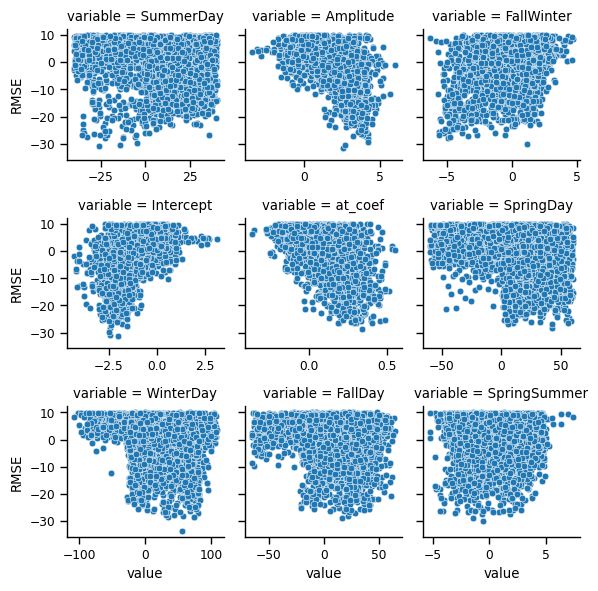

In [23]:
sns.relplot(bbplt, x="value", y="RMSE", col="variable",
            col_wrap=3, height=2, facet_kws={"sharex": False})

### Site Coefficient Distributions

In [24]:
# Identify whether sites allow no behavioral sets, behavioral sets but no improvement, or improvement
behbins["shift"] = 0
behbins.loc[-behbins["RMSE"].isna(), "shift"] = 1
behbins.loc[behbins["RMSE"] < 0, "shift"] = 2
names = pd.DataFrame({"shift": [0, 1, 2], "which": ["No Behavioral", "Behavioral", "Improved"]})
shifts = (behbins.groupby(["id", "variable"])[["ref_value", "shift"]].max().
          reset_index().
          merge(names, on="shift"))
shifts

,id,variable,ref_value,shift,which
0,01010000,Amplitude,11.664508,2,Improved
1,01010000,FallDay,323.000000,2,Improved
2,01010000,FallWinter,3.269881,2,Improved
3,01010000,Intercept,8.227527,2,Improved
4,01010000,SpringDay,120.000000,2,Improved
...,...,...,...,...,...
8284,453004122510301,SpringDay,158.000000,0,No Behavioral
8285,453004122510301,SpringSummer,0.377075,0,No Behavioral
8286,453004122510301,SummerDay,205.000000,0,No Behavioral
8287,453004122510301,WinterDay,85.000000,0,No Behavioral


Looking at where improvements occur, we see:

- Intercept: curiously, no-behavioral and improved have about the same distribution, whereas behavioral-but-not-improved tends to occur for somewhat higher Intercepts. One hypothesis would be that colder streams are both more sensitive and more likely to overestimate Intercept.
- Amplitude: improved > behavioral > no-behavioral; in general, there's more equifinality for higher Amplitudes. Behavioral also has the narrowest distribution, with sites at either extreme tending to be either improved or no-behavioral. No-behavioral never occurs for negative amplitude, suggesting that that is always an error.
- SpringSummer: No-behavioral sites have a much higher SpringSummer coefficient than either behavioral or improved, which have nearly identical distributions. This suggests that a high SpringSummer coefficient is almost always correct, whereas a low one is likely to be either insensitive or incorrect.
- FallWinter: improved has a heavier negative tail, suggesting that negative FallWinter values are likely to be errors, while behavioral-but-not-improved has a rather narrow distribution. The centers are all similar.
- SpringDay: Improved and behavioral are bimodal, centered on days ~120 and ~180. No-behavioral, on the other hand, is centered on day 150. So extremes are relatively likely to be insensitive or in error, while centered values are more likely to be correct.
- SummerDay: Same as SpringDay.
- FallDay: little difference.
- WinterDay: All distributions are bimodal with the same two modes. However, behavioral-but-not-improved sites are concentrated at late WinterDays.
- Sensitivity: All within the same range, but behavioral > improved > no-behavioral for center.

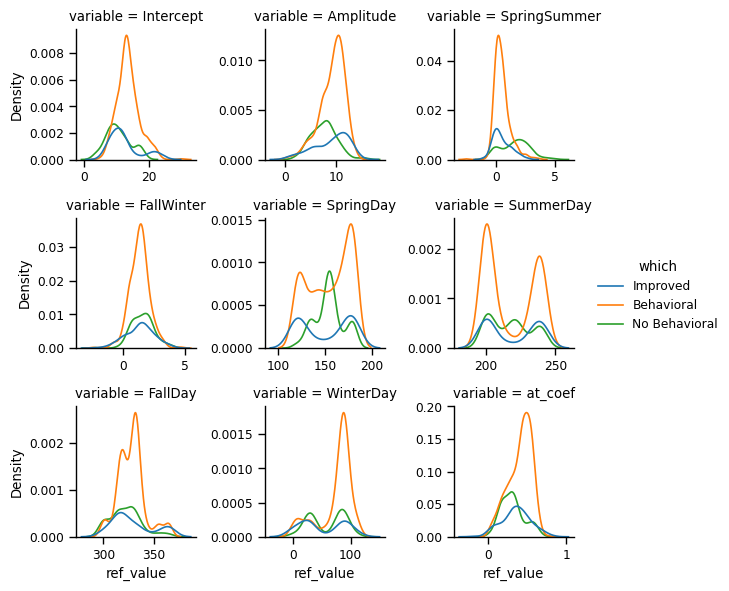

In [27]:
sns.displot(shifts, x="ref_value", col="variable", col_wrap=3, hue="which",
            col_order=["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay",
                       "SummerDay", "FallDay", "WinterDay", "at_coef"],
            kind="kde", height=2, facet_kws={"sharex": False, "sharey": False})

### Change Distributions

We see significant variation in the allowable range of variation. The dates are all low-sensitivity, with some of them even weighted towards larger offsets. Intercept and Amplitude are extremely sensitive, with no behavioral parameter sets above ~40% offset for Amplitude, and ~15% for Intercept.

Restricting the bins to exclude the lower bins:

- Improved or low-penalty perturbations for Intercept are more likely to be higher (up to 15%), while higher-penalty behavioral sets are weighted towards low change.
- Same story for Amplitude, up to 40%.
- SpringSummer changes are weighted higher, tending to be around 20-50% for both improved and behavioral parameter sets.
- FallWinter, like Intercept and Amplitude, sees heavier right tails for improved/low-penalty changes.
- SpringDay changes tend to be large. Combined with the above analysis, this suggests that improved sites were put in the wrong mode of the bimodal distribution in fitting, but which mode - or the middle - tends to be relatively insensitive.
- SummerDay changes are even more likely to be large. Same story.
- FallDay changes tend to be smaller, though they can be large. This is probably because it's unimodal but low-sensitivity.
- WinterDay changes tend to be either small or large, with a bimodal distribution (weighted towards small). Improvement-changes are usually large. Again, bimodal and low-sensitivity.
- Sensitivity changes are weighted smaller, with a maximum shift of 50% and modes around 5-20%. As above, improved/low-penalty changes have heavier tails, but remain focused on small changes.

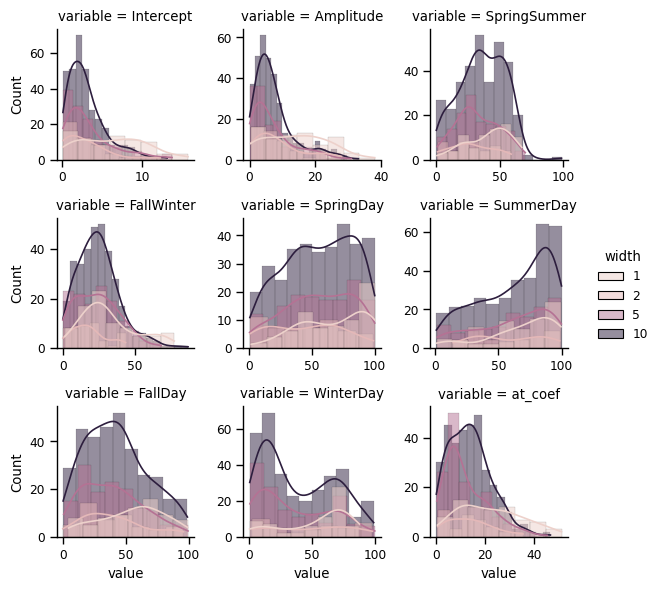

In [30]:
left_end = pd.DataFrame({"width": [1, 2, 5, 10], "lower": [-99, 1, 2, 5]})
ewid = (bbplt.assign(value=lambda x: x["value"].abs()/x["ref_range"]*100).
        reset_index().
        merge(left_end, on="width"))
ewid = ewid.loc[ewid["RMSE"] > ewid["lower"]].groupby(["id", "variable", "width"])["value"].max().reset_index()
sns.displot(ewid, x="value", col="variable", hue="width", col_wrap=3, height=2, kde=True, common_bins=False,
            facet_kws={"sharex": False, "sharey": False},
           col_order=["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay",
                       "SummerDay", "FallDay", "WinterDay", "at_coef"],)

### Site Info Distributions

I'm also curious how shifts are distributed with physical conditions.

In [51]:
swinf = shifts.merge(site_info, how="left", on="id").melt(["id", "variable", "ref_value", "shift", "which"],
           var_name="info",
           value_name="value")

Do we notice anything?

- Behavioral sites are warmer than the other two (water temp and air temp).
- Behavioral and improved sites are wetter (precip and vp) than no-behavioral.
- No-behavioral sites have a heavier tail and higher mean in elevation (mean and minimum). In turn, behavioral sites have a much heavier tail than improved sites, which are almost exclusively <1000 m.
- Behavioral sites are further south than improved sites, which are south of no-behavioral sites.
- All sites are east-weighted, but improved sites almost never occur west of the 100th.
- No-behavioral sites are a little northwest-flowing-weighted compared to the others, which is probably driven by their location.
- Improved and behavioral sites have heavy tails in freezing days compared to no-behavioral, though modes are similar.
- Land cover distributions (including riparian canopy) are all very similar. So's area. No effect there.

This has been an interesting analysis, but this set of observations shows it's not that useful for coefficient estimation, since the sites that tend to struggle (e.g., high elevation, western, dry) are actually under-represented in the behavioral/improved groups. So they tend to be fitted correctly, but just hard to predict. Which, come to think of it, makes sense, since being able to get things "more wrong" would tend to result in improved performance.

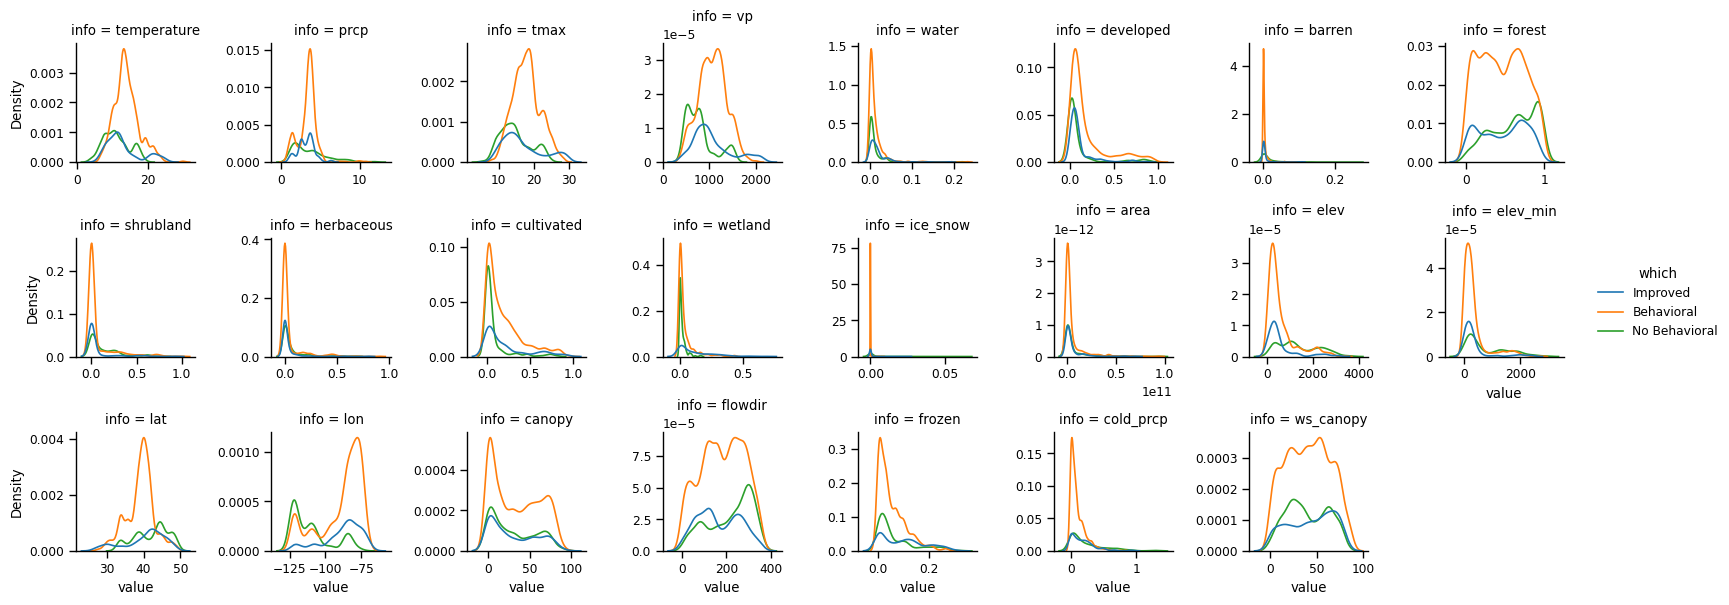

In [55]:
sns.displot(swinf, x="value", col="info", col_wrap=8, hue="which",
            kind="kde", height=2, facet_kws={"sharex": False, "sharey": False})

### Site RMSE Distributions

In [61]:
rmses = shifts.groupby("id").head(1).merge(reference, on="id", how="left")
rmses

,id,variable,ref_value,shift,which,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,RMSE
0,01010000,Amplitude,11.664508,2,Improved,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.313388,1.819758
1,01011000,Amplitude,11.735706,2,Improved,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.271996,1.510067
2,01018035,Amplitude,12.007753,2,Improved,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.364230,1.560736
3,01038000,Amplitude,12.433309,2,Improved,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.380036,1.318067
4,010642505,Amplitude,9.252760,1,Behavioral,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.333147,1.141534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,385903107210800,Amplitude,9.258731,2,Improved,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.375744,1.682636
917,394220106431500,Amplitude,7.357272,0,No Behavioral,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.257349,1.281264
918,402114105350101,Amplitude,7.339022,0,No Behavioral,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.329488,1.207342
919,404417108524900,Amplitude,8.047868,1,Behavioral,9.623788,8.047868,330.0,75.0,157.0,204.0,1.818095,0.949920,0.286131,1.483574


By original RMSE, typical distributions are very similar, though no-behavioral had slightly lower errors.

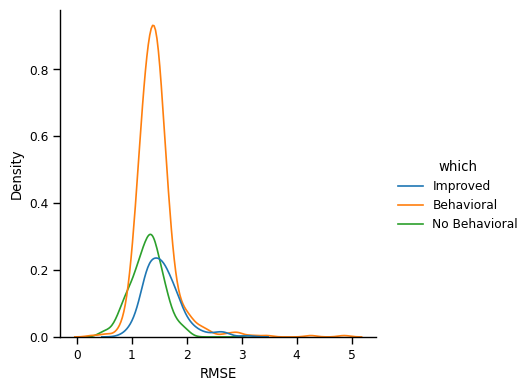

In [62]:
sns.displot(rmses, x="RMSE", hue="which", kind="kde", height=4)